Now I'm testing attention calculation/visualization.

In [1]:
from wn import net
from wn.data import MatchHistoryDataset
from wn import diag

import torch
from torch.utils.data import DataLoader, Subset
from torch import nn
from torch.optim import AdamW

import pickle
import os
from time import perf_counter

import seaborn as sns

In [2]:
# Set all the training parameters up here.

# I don't want to type training_parameters a bunch of times...
with open("../model/test_model_config.pkl", "rb") as f:
    tp = pickle.load(f)

In [3]:
# Load the tensorized data
with open("../data/tensor_list.pkl", "rb") as f:
    input_data, y = pickle.load(f)

with open("../data/history_tensor_list.pkl", "rb") as f:
    history_data, p1_id, p2_id = pickle.load(f)

# Load the interfaces
with open("../data/match_interface.pkl", "rb") as f:
    match_interface = pickle.load(f)

with open("../data/history_interface.pkl", "rb") as f:
    history_interface = pickle.load(f)

# Make a dataset
ds = MatchHistoryDataset(
    input_data, y, history_data, p1_id, p2_id, history_size=tp["history_length"]
)

# Split into training and validation
idx = torch.randperm(len(input_data["p1_dob"]))
split_idx = int(idx.shape[0] * tp["validation_set_size"])
train_ds = Subset(ds, idx[split_idx:])
validation_ds = Subset(ds, idx[:split_idx])

In [4]:
# Set up the network for a test.

# Special tabular input layer
table_input_layer = net.TabularInputLayer(
    interface=match_interface,
    col_encoding_size=tp["col_encoding_size"],
    embedding_size=tp["dim_model"] - tp["col_encoding_size"],
    append_cls=True,
)

# Input layer for sequential features, one for each player
p1_sequence_input_layer = net.SequentialInputLayer(
    interface=history_interface,
    sequence_encoding_size=[tp["history_length"], tp["col_encoding_size"]],
    embedding_size=tp["dim_model"] - tp["col_encoding_size"],
    learnable_padding=tp["learnable_padding"],
)

p2_sequence_input_layer = net.SequentialInputLayer(
    interface=history_interface,
    sequence_encoding_size=[tp["history_length"], tp["col_encoding_size"]],
    embedding_size=tp["dim_model"] - tp["col_encoding_size"],
    learnable_padding=tp["learnable_padding"],
)

output_layers = net.OutputLayers(tp["dim_model"], tp["n_output_layers"])

# Transformer encoder
tr = nn.TransformerEncoder(
    encoder_layer=nn.TransformerEncoderLayer(
        d_model=tp["dim_model"],
        nhead=tp["n_transformer_heads"],
        dim_feedforward=tp["dim_ff"],
        batch_first=True,
        norm_first=True,
    ),
    num_layers=tp["n_transformer_layers"],
)

whole_net = net.FusionNet(
    table_input_layer=table_input_layer,
    p1_sequence_input_layer=p1_sequence_input_layer,
    p2_sequence_input_layer=p2_sequence_input_layer,
    transformer=tr,
    output_layer=output_layers,
)

n_weights = sum([p.numel() for p in whole_net.parameters() if p.requires_grad])
print(f"Network has {n_weights} weights.")

# Setup device
device = "cuda:0" if torch.cuda.is_available() else "cpu"
whole_net.to(device)

# Load the state_dict

whole_net.load_state_dict(torch.load("../model/test_model.pt"))
print("Loaded saved model")

print(f"Using {device}")

Network has 101201 weights.
Loaded saved model
Using cuda:0


In [5]:
# Setup attention saving

# Create a hook (I think?). We can use this to get the attention later.
save_output = diag.SaveOutput()

# This is tremendously nasty
for layer in whole_net.transformer.layers:
    diag.patch_attention(layer.self_attn)

    # The return can be used to remove the hook with hook_handle.remove()
    hook_handle = layer.self_attn.register_forward_hook(save_output)

# The return can be used to remove the hook with hook_handle.remove()
# hook_handle = whole_net.transformer.layers[-1].self_attn.register_forward_hook(save_output)


In [6]:
save_output.clear()

# Get some data and send it through the network
train_dl = DataLoader(
    train_ds, batch_size=4096, shuffle=True, num_workers=0
)

batch = next(iter(train_dl))

# Get a batch
mx, sx1, mask1, sx2, mask2, y = batch

mx = net.to_(mx, device)
sx1 = net.to_(sx1, device)
mask1 = mask1.to(device)
sx2 = net.to_(sx2, device)
mask2 = mask2.to(device)
y = y.to(device)

# Through the network
y_hat = whole_net(mx, sx1, mask1, sx2, mask2)

predictions = y_hat > 0.5
print((predictions == y).float().mean())

tensor(0.6411, device='cuda:0')


<AxesSubplot: >

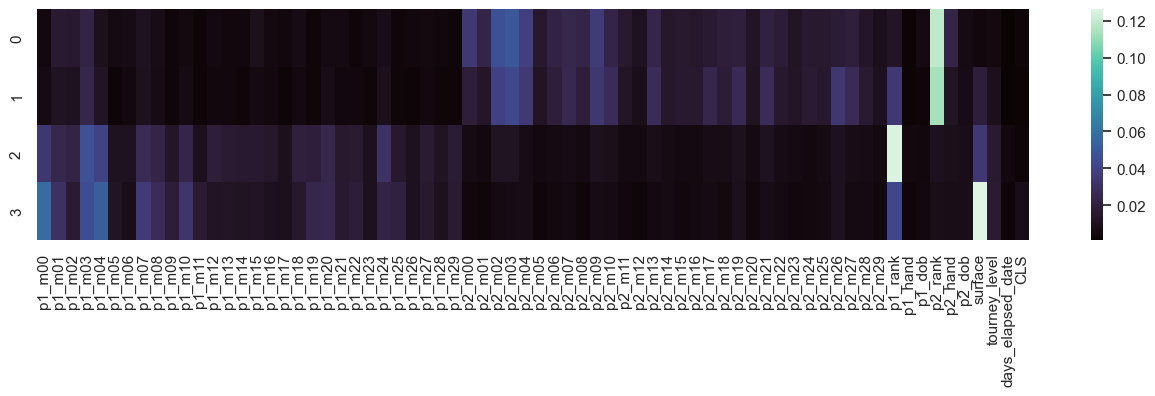

In [7]:
# Show the attention by layer for some specific position's output.
# I'm not sure this makes sense.
graph_data = torch.cat(
    [
        output[:, :, -1, :].mean(dim=0).mean(dim=0, keepdim=True)
        for output in save_output.outputs
    ],
    dim=0
)


sns.set(rc={'figure.figsize':(16, 3)})
sns.heatmap(
    data=graph_data.cpu().detach().numpy(),
    xticklabels=whole_net.name_positions(),
    cmap="mako",
)

<AxesSubplot: >

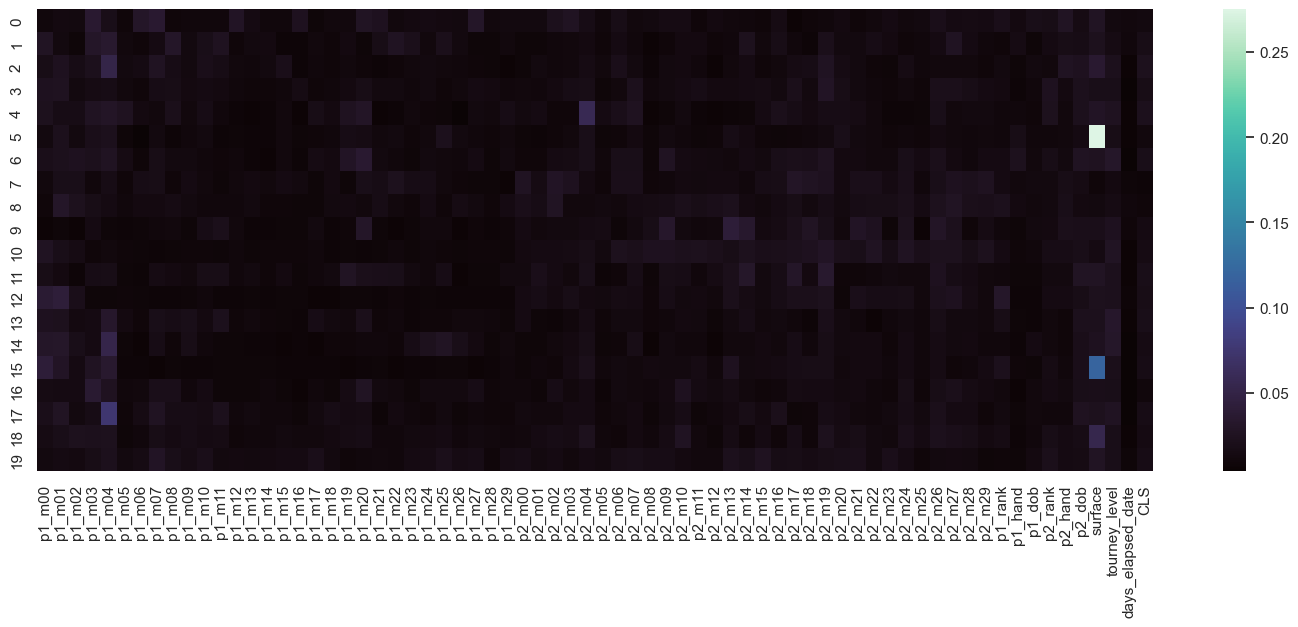

In [10]:
# By observation

# Let's try to get total attention weight. I think this does make sense.
# Select the first five observations in the batch, then every head, then the CLS token position.
total_weight = diag.total_attention(save_output.outputs)[0:20, 0, -1, :]

sns.set(rc={'figure.figsize':(18, 6)})
sns.heatmap(data=total_weight.cpu().detach(), xticklabels=whole_net.name_positions(), cmap="mako")

<AxesSubplot: >

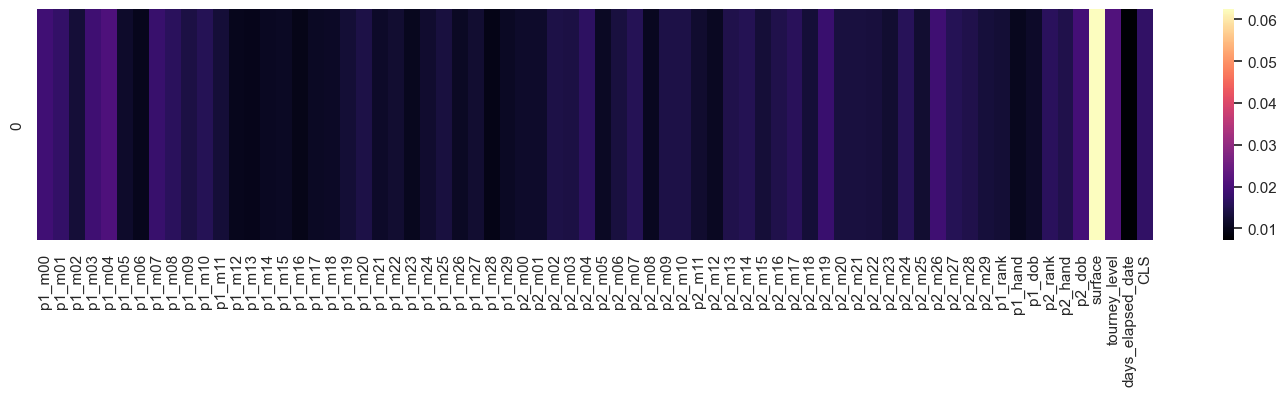

In [13]:
# Mean

total_weight = diag.total_attention(save_output.outputs).mean(dim=[0, 1])[[-1], :]
sns.set(rc={'figure.figsize':(18, 3)})
sns.heatmap(data=total_weight.cpu().detach(), xticklabels=whole_net.name_positions(), cmap="magma")

<AxesSubplot: >

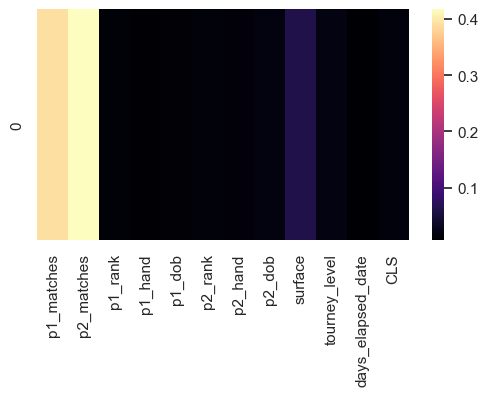

In [28]:
# Condense the match histories into single positions

p1_total = total_weight[:, 0:30].sum(dim=1, keepdim=True)
p2_total = total_weight[:, 30:60].sum(dim=1, keepdim=True)

aggregated_attention = torch.cat([p1_total, p2_total, total_weight[:, 60:]], dim=1)
labels = ["p1_matches", "p2_matches"] + whole_net.name_positions()[-10:]

sns.set(rc={'figure.figsize':(6, 3)})
sns.heatmap(data=aggregated_attention.cpu().detach(), xticklabels=labels, cmap="magma")

In [27]:
labels = ["p1_matches", "p2_matches"] + whole_net.name_positions()[-10:]